# Spatial-Temporal Graph Neural Network (Spatial-Temporal GNN)

Prediction of the intention of pedestrians to cross the street or not, using Graph Neural Networks and the coordinates of their skeleton that was previously generated using a Pose Estimation network in the JAAD dataset.

**Input:** Pedestrian skeleton graph.

**Output:** Binary classification (crossing or not crossing the street).

In [ ]:
import numpy as np

from torch import from_numpy
from torch import cuda
from torch import no_grad
from torch import optim

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt

import pandas as pd

%matplotlib inline

from Code.GNN import *
from Code.SkeletonsDataset import *
from Code.ModelTrainEvaluate import *
from Code.MetricsPlots import *

import time

# Dataset

## Training dataset

In [2]:
datasetName = 'JAAD'
subset = 'train'
poseEstimator = 'AlphaPose' #'OpenPose'
info = 87
data_augm = 'dataAugmentation4'

numberOfJoints = 25 if poseEstimator == 'OpenPose' else 18

data_augmentation_name = '' if data_augm == None or data_augm == '' else '_' + data_augm

train_dataset = SkeletonsDataset('Data/' + datasetName + '/' + subset + '_jaad_' + poseEstimator + data_augmentation_name + '.csv',
                                 normalization='minmax', target='cross', info=info,
                                 remove_undetected=True, numberOfJoints=numberOfJoints)

print('train_dataset len:', len(train_dataset))
print('Temporal dimension length:', len(train_dataset.data[0].x_temporal))
print('Shape of each skeletons data (x):', train_dataset.data[0].x_temporal[0].shape)

train_dataset.loadedData

train_dataset len: 67950
Temporal dimension length: 87
Shape of each skeletons data (x): torch.Size([18, 3])


,video,frame,ped_id,skeleton,skeleton_detected,cross,reaction,hand_gesture,look,action,nod,occlusion,bbox,bbox_center_x,bbox_center_y,skeleton_center_x,skeleton_center_y
0,video_0001,0,0_1_3b,"[[527.3912353515625, 751.2621459960938, 0.7392...",True,not-crossing,__undefined__,__undefined__,not-looking,standing,__undefined__,none,"[465.0, 730.0, 533.0, 848.0]",499.0,789.0,505.166349,774.751916
1,video_0001,1,0_1_3b,"[[523.9093017578125, 752.7357177734375, 0.7035...",True,not-crossing,__undefined__,__undefined__,not-looking,standing,__undefined__,none,"[463.0, 730.0, 532.0, 848.0]",497.5,789.0,502.850274,775.266100
2,video_0001,2,0_1_3b,"[[1453.533935546875, 678.0730590820312, 0.9457...",True,not-crossing,__undefined__,__undefined__,not-looking,standing,__undefined__,none,"[461.0, 730.0, 531.0, 849.0]",496.0,789.5,1448.740197,742.659351
3,video_0001,3,0_1_3b,"[[520.5011596679688, 752.8726196289062, 0.7747...",True,not-crossing,__undefined__,__undefined__,not-looking,standing,__undefined__,none,"[459.0, 730.0, 530.0, 849.0]",494.5,789.5,498.565045,774.777420
4,video_0001,4,0_1_3b,"[[1459.4296875, 681.8412475585938, 0.931000173...",True,not-crossing,__undefined__,__undefined__,not-looking,standing,__undefined__,none,"[458.0, 731.0, 530.0, 851.0]",494.0,791.0,1455.189830,743.797670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123605,video_0345,132,0_345_2700b_augm,"[[29.079733, 625.24414, 0.053062987], [54.0849...",True,not-crossing,__undefined__,__undefined__,not-looking,walking,__undefined__,part,"[3.0, 585.0, 157.0, 1046.0]",80.0,815.5,50.422588,787.651923
123606,video_0345,133,0_345_2700b_augm,"[[22.076777, 584.6351, 0.65492535], [36.781116...",True,not-crossing,__undefined__,__undefined__,not-looking,walking,__undefined__,part,"[3.0, 597.0, 137.0, 1022.0]",70.0,809.5,39.776443,770.073103
123607,video_0345,134,0_345_2700b_augm,"[[14.360211, 603.4249, 0.28389785], [24.40079,...",True,not-crossing,__undefined__,__undefined__,not-looking,walking,__undefined__,part,"[3.0, 614.0, 117.0, 993.0]",60.0,803.5,25.795314,781.366279
123608,video_0345,135,0_345_2700b_augm,"[[9.584961, 637.0151, 0.4538917], [16.535666, ...",True,not-crossing,__undefined__,__undefined__,not-looking,walking,__undefined__,part,"[3.0, 636.0, 96.0, 960.0]",49.5,798.0,26.987405,767.314585


Important columns:

In [3]:
train_dataset.loadedData[['video','frame','skeleton','skeleton_detected','cross']]

,video,frame,skeleton,skeleton_detected,cross
0,video_0001,0,"[[527.3912353515625, 751.2621459960938, 0.7392...",True,not-crossing
1,video_0001,1,"[[523.9093017578125, 752.7357177734375, 0.7035...",True,not-crossing
2,video_0001,2,"[[1453.533935546875, 678.0730590820312, 0.9457...",True,not-crossing
3,video_0001,3,"[[520.5011596679688, 752.8726196289062, 0.7747...",True,not-crossing
4,video_0001,4,"[[1459.4296875, 681.8412475585938, 0.931000173...",True,not-crossing
...,...,...,...,...,...
123605,video_0345,132,"[[29.079733, 625.24414, 0.053062987], [54.0849...",True,not-crossing
123606,video_0345,133,"[[22.076777, 584.6351, 0.65492535], [36.781116...",True,not-crossing
123607,video_0345,134,"[[14.360211, 603.4249, 0.28389785], [24.40079,...",True,not-crossing
123608,video_0345,135,"[[9.584961, 637.0151, 0.4538917], [16.535666, ...",True,not-crossing


Number of elements per class:

Training dataset total rows: 121668
Training dataset crossing class samples: 71128
Training dataset not-crossing class samples: 50540


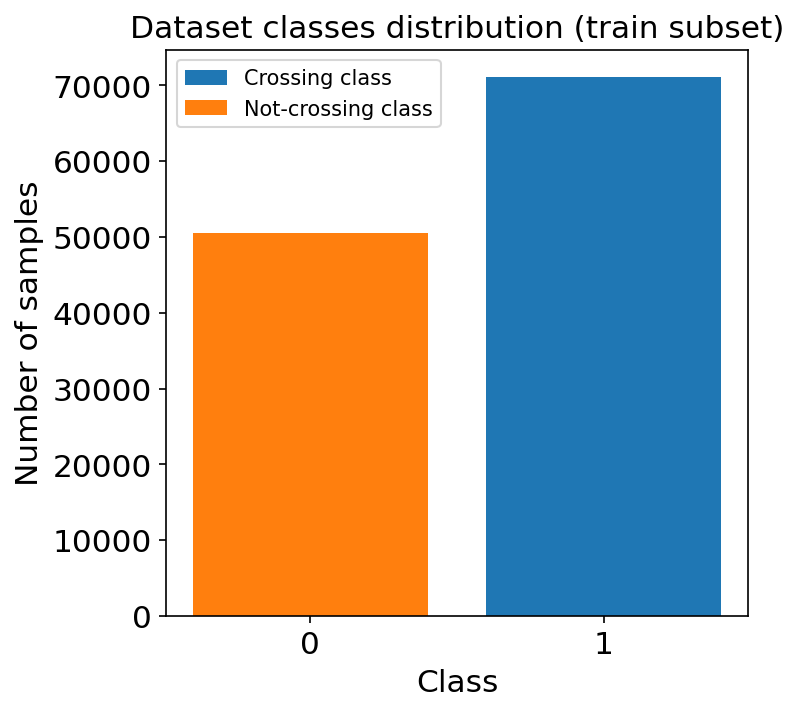

In [4]:
totalRows = len(train_dataset.loadedData)
crossingRows = len(train_dataset.loadedData[train_dataset.loadedData['cross']=='crossing'])
nocrossingRows = len(train_dataset.loadedData[train_dataset.loadedData['cross']!='crossing'])

print('Training dataset total rows:', totalRows)
print('Training dataset crossing class samples:', crossingRows)
print('Training dataset not-crossing class samples:', nocrossingRows)

plt.figure(figsize=(5,5), dpi=150)
plt.bar(1, crossingRows, label='Crossing class')
plt.bar(0, nocrossingRows, label='Not-crossing class')
plt.legend(loc='upper left')
plt.xticks([0, 1], size=15)
plt.yticks(size=15)
plt.xlabel('Class', size=15)
plt.ylabel('Number of samples', size=15)
plt.title('Dataset classes distribution (train subset)', size=15)
plt.show()

## Showing a skeleton

In [5]:
#train_dataset.showSkeleton(videoNum=0, frameNum=0, textSize=14, showLegend=True, normalizedSkeletons=True)

#train_dataset.showSkeleton(videoNum="video_0041", frameNum=0, textSize=14, showLegend=True, normalizedSkeletons=False)

## Validation dataset

In [6]:
subset = 'val'

val_dataset = SkeletonsDataset('Data/' + datasetName + '/' + subset + '_jaad_' + poseEstimator + '.csv',
                           normalization='minmax', target='cross', info=info,
                           remove_undetected=True, numberOfJoints=numberOfJoints)

In [7]:
print('val_dataset len:', len(val_dataset))
print('Temporal dimension length:', len(val_dataset.data[0].x_temporal))
print('Shape of each skeletons data (x):', val_dataset.data[0].x_temporal[0].shape)

val_dataset len: 5495
Temporal dimension length: 87
Shape of each skeletons data (x): torch.Size([18, 3])


Important columns:

In [8]:
val_dataset.loadedData[['video','frame','skeleton','skeleton_detected','cross']].head(10)

,video,frame,skeleton,skeleton_detected,cross
0,video_0006,0,"[[897.4727172851562, 720.0595703125, 0.3848784...",True,not-crossing
1,video_0006,1,"[[897.4951782226562, 720.0362548828125, 0.3810...",True,not-crossing
2,video_0006,2,"[[896.587158203125, 718.1592407226562, 0.28576...",True,not-crossing
3,video_0006,3,"[[896.0133056640625, 719.7392578125, 0.3119539...",True,not-crossing
4,video_0006,4,"[[894.0762329101562, 721.4017333984375, 0.4980...",True,not-crossing
5,video_0006,5,"[[893.3912963867188, 721.2113037109375, 0.4019...",True,not-crossing
6,video_0006,6,"[[1049.799072265625, 731.6937255859375, 0.1670...",True,not-crossing
7,video_0006,7,"[[898.4447021484375, 723.4312744140625, 0.2557...",True,not-crossing
8,video_0006,8,"[[891.2755126953125, 720.154541015625, 0.29131...",True,not-crossing
9,video_0006,9,"[[890.40771484375, 719.7791748046875, 0.256414...",True,not-crossing


Number of elements per class:

Validation dataset total rows: 9482
Validation dataset crossing class samples: 5213
Validation dataset not-crossing class samples: 4269


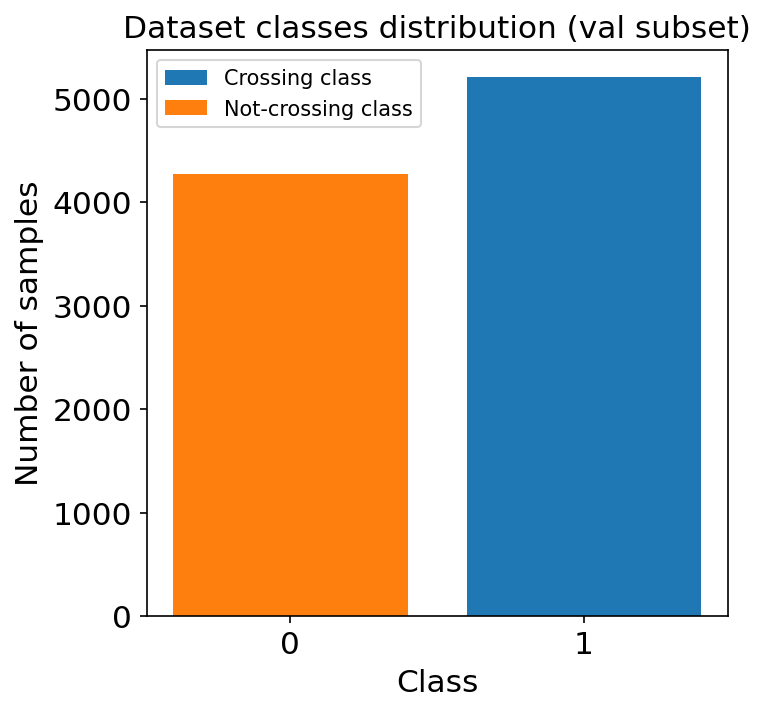

In [9]:
totalRows = len(val_dataset.loadedData)
crossingRows = len(val_dataset.loadedData[val_dataset.loadedData['cross']=='crossing'])
nocrossingRows = len(val_dataset.loadedData[val_dataset.loadedData['cross']!='crossing'])

print('Validation dataset total rows:', totalRows)
print('Validation dataset crossing class samples:', crossingRows)
print('Validation dataset not-crossing class samples:', nocrossingRows)

plt.figure(figsize=(5,5), dpi=150)
plt.bar(1, crossingRows, label='Crossing class')
plt.bar(0, nocrossingRows, label='Not-crossing class')
plt.legend(loc='upper left')
plt.xticks([0, 1], size=15)
plt.yticks(size=15)
plt.xlabel('Class', size=15)
plt.ylabel('Number of samples', size=15)
plt.title('Dataset classes distribution (val subset)', size=15)
plt.show()

Since the classes of the two datasets are unbalanced, we cannot rely only on accuracy as our metric.

## Showing a skeleton

In [10]:
#val_dataset.showSkeleton(videoNum=0, frameNum=0, textSize=14, showLegend=True, normalizedSkeletons=True)

# Training

In [11]:
numberOfClasses = 2

y = train_dataset.loadedData['cross'].to_numpy()
y = np.where(y=='crossing', 1, 0)
bc = np.bincount(y)

class_weights = len(train_dataset.loadedData) / (numberOfClasses * bc)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print('class_weights:', class_weights)

class_weights: tensor([1.2037, 0.8553])


In [12]:
# First element of training subset:
t0 = train_dataset[0]

# Node features:
t1 = t0.x_temporal[0]

# Number of nodes:
numberOfNodes = t1.shape[0]

# Number of dimensions of each node features:
embed_dim = t1.shape[1]

print('Number of nodes per skeleton:', numberOfNodes)
print('Number of features per node:', embed_dim)

Number of nodes per skeleton: 18
Number of features per node: 3


In [13]:
net = 'TGCN'
dropout = 0.5
learning_rate = 0.001
num_epochs = 1000
batch_size = 10000

device = torch.device('cuda')
model = SpatialTemporalGNN(embed_dim, numberOfClasses, numberOfNodes, net=net,
                           filterSize=embed_dim, dropout=dropout, batchSize=batch_size).to(device)

#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

crit = torch.nn.BCELoss()#weight=class_weights)

train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

loss_values = []

metrics_train = []
metrics_val = []

training_times_per_epoch = []

for epoch in range(num_epochs):

    start_time_epoch = time.time()
    
    train_loss = train(model, train_loader, device, optimizer, crit)
    
    end_time_epoch = time.time()
    
    training_times_per_epoch.append(end_time_epoch - start_time_epoch)
        
    loss_values.append(train_loss)

    train_metrics = evaluate(model, train_loader, device, computed_loss=train_loss)
    val_metrics = evaluate(model, val_loader, device, loss_crit=crit)

    metrics_train.append(train_metrics)
    metrics_val.append(val_metrics)
    
    if num_epochs <= 100 or epoch % 10 == 0:
        
        print("Training time per epoch:", round(end_time_epoch - start_time_epoch, 2), "seconds")
        print_evaluation_train_val(epoch, train_metrics, val_metrics)
        
print("Total training time:", round(np.sum(training_times_per_epoch)/60, 2), "minutes")

Training time per epoch: 15.47 seconds
Epoch:                           001
Train Loss:                   0.7225  -  Validation Loss:                   0.6589
Train Accuracy:               0.6927  -  Validation Accuracy:               0.6675
Train Balanced accuracy:      0.5000  -  Validation Balanced accuracy:      0.5000
Train Precision:              0.6927  -  Validation Precision:              0.6675
Train Recall:                 1.0000  -  Validation Recall:                 1.0000
Train f1-score:               0.8184  -  Validation f1-score:               0.8006
 


Training time per epoch: 11.65 seconds
Epoch:                           011
Train Loss:                   0.6387  -  Validation Loss:                   0.6332
Train Accuracy:               0.6927  -  Validation Accuracy:               0.6675
Train Balanced accuracy:      0.5000  -  Validation Balanced accuracy:      0.5000
Train Precision:              0.6927  -  Validation Precision:              0.6675
Train Recall: 

Training time per epoch: 11.94 seconds
Epoch:                           151
Train Loss:                   0.5495  -  Validation Loss:                   0.4921
Train Accuracy:               0.7840  -  Validation Accuracy:               0.8036
Train Balanced accuracy:      0.7036  -  Validation Balanced accuracy:      0.7603
Train Precision:              0.8028  -  Validation Precision:              0.8288
Train Recall:                 0.9122  -  Validation Recall:                 0.8896
Train f1-score:               0.8540  -  Validation f1-score:               0.8581
 


Training time per epoch: 12.02 seconds
Epoch:                           161
Train Loss:                   0.5498  -  Validation Loss:                   0.4895
Train Accuracy:               0.7855  -  Validation Accuracy:               0.8078
Train Balanced accuracy:      0.7063  -  Validation Balanced accuracy:      0.7683
Train Precision:              0.8046  -  Validation Precision:              0.8357
Train Recall: 

Training time per epoch: 10.87 seconds
Epoch:                           301
Train Loss:                   0.5366  -  Validation Loss:                   0.4710
Train Accuracy:               0.7901  -  Validation Accuracy:               0.8200
Train Balanced accuracy:      0.7125  -  Validation Balanced accuracy:      0.7843
Train Precision:              0.8082  -  Validation Precision:              0.8473
Train Recall:                 0.9138  -  Validation Recall:                 0.8909
Train f1-score:               0.8578  -  Validation f1-score:               0.8686
 


Training time per epoch: 10.98 seconds
Epoch:                           311
Train Loss:                   0.5343  -  Validation Loss:                   0.4697
Train Accuracy:               0.7896  -  Validation Accuracy:               0.8204
Train Balanced accuracy:      0.7119  -  Validation Balanced accuracy:      0.7846
Train Precision:              0.8078  -  Validation Precision:              0.8474
Train Recall: 

Training time per epoch: 10.73 seconds
Epoch:                           451
Train Loss:                   0.5334  -  Validation Loss:                   0.4652
Train Accuracy:               0.7921  -  Validation Accuracy:               0.8184
Train Balanced accuracy:      0.7149  -  Validation Balanced accuracy:      0.7802
Train Precision:              0.8095  -  Validation Precision:              0.8432
Train Recall:                 0.9152  -  Validation Recall:                 0.8942
Train f1-score:               0.8591  -  Validation f1-score:               0.8680
 


Training time per epoch: 10.72 seconds
Epoch:                           461
Train Loss:                   0.5313  -  Validation Loss:                   0.4625
Train Accuracy:               0.7921  -  Validation Accuracy:               0.8204
Train Balanced accuracy:      0.7150  -  Validation Balanced accuracy:      0.7824
Train Precision:              0.8096  -  Validation Precision:              0.8445
Train Recall: 

Training time per epoch: 10.22 seconds
Epoch:                           601
Train Loss:                   0.5293  -  Validation Loss:                   0.4613
Train Accuracy:               0.7951  -  Validation Accuracy:               0.8197
Train Balanced accuracy:      0.7178  -  Validation Balanced accuracy:      0.7793
Train Precision:              0.8109  -  Validation Precision:              0.8412
Train Recall:                 0.9183  -  Validation Recall:                 0.8997
Train f1-score:               0.8613  -  Validation f1-score:               0.8695
 


Training time per epoch: 10.21 seconds
Epoch:                           611
Train Loss:                   0.5285  -  Validation Loss:                   0.4595
Train Accuracy:               0.7945  -  Validation Accuracy:               0.8229
Train Balanced accuracy:      0.7172  -  Validation Balanced accuracy:      0.7843
Train Precision:              0.8106  -  Validation Precision:              0.8451
Train Recall: 

Training time per epoch: 10.59 seconds
Epoch:                           751
Train Loss:                   0.5281  -  Validation Loss:                   0.4608
Train Accuracy:               0.7958  -  Validation Accuracy:               0.8173
Train Balanced accuracy:      0.7179  -  Validation Balanced accuracy:      0.7741
Train Precision:              0.8107  -  Validation Precision:              0.8364
Train Recall:                 0.9202  -  Validation Recall:                 0.9029
Train f1-score:               0.8620  -  Validation f1-score:               0.8684
 


Training time per epoch: 10.43 seconds
Epoch:                           761
Train Loss:                   0.5281  -  Validation Loss:                   0.4583
Train Accuracy:               0.7966  -  Validation Accuracy:               0.8235
Train Balanced accuracy:      0.7174  -  Validation Balanced accuracy:      0.7799
Train Precision:              0.8099  -  Validation Precision:              0.8391
Train Recall: 

Training time per epoch: 10.52 seconds
Epoch:                           901
Train Loss:                   0.5269  -  Validation Loss:                   0.4594
Train Accuracy:               0.7979  -  Validation Accuracy:               0.8195
Train Balanced accuracy:      0.7190  -  Validation Balanced accuracy:      0.7744
Train Precision:              0.8109  -  Validation Precision:              0.8352
Train Recall:                 0.9238  -  Validation Recall:                 0.9089
Train f1-score:               0.8636  -  Validation f1-score:               0.8705
 


Training time per epoch: 10.75 seconds
Epoch:                           911
Train Loss:                   0.5297  -  Validation Loss:                   0.4591
Train Accuracy:               0.7975  -  Validation Accuracy:               0.8209
Train Balanced accuracy:      0.7180  -  Validation Balanced accuracy:      0.7762
Train Precision:              0.8101  -  Validation Precision:              0.8363
Train Recall: 

In [14]:
modelName = net + '_' + poseEstimator + '_info=' + str(info) + '_dropout=' + str(dropout) + data_augmentation_name
modelName = modelName + '_epoch=' + str(num_epochs)

print('Saving model:', modelName)

torch.save(model.state_dict(), 'exportedModels/' + datasetName + '/' + modelName)

Saving model: TGCN_AlphaPose_info=87_dropout=0.5_dataAugmentation4_epoch=1000


## Model performance plots

In [15]:
epochs_step = 100

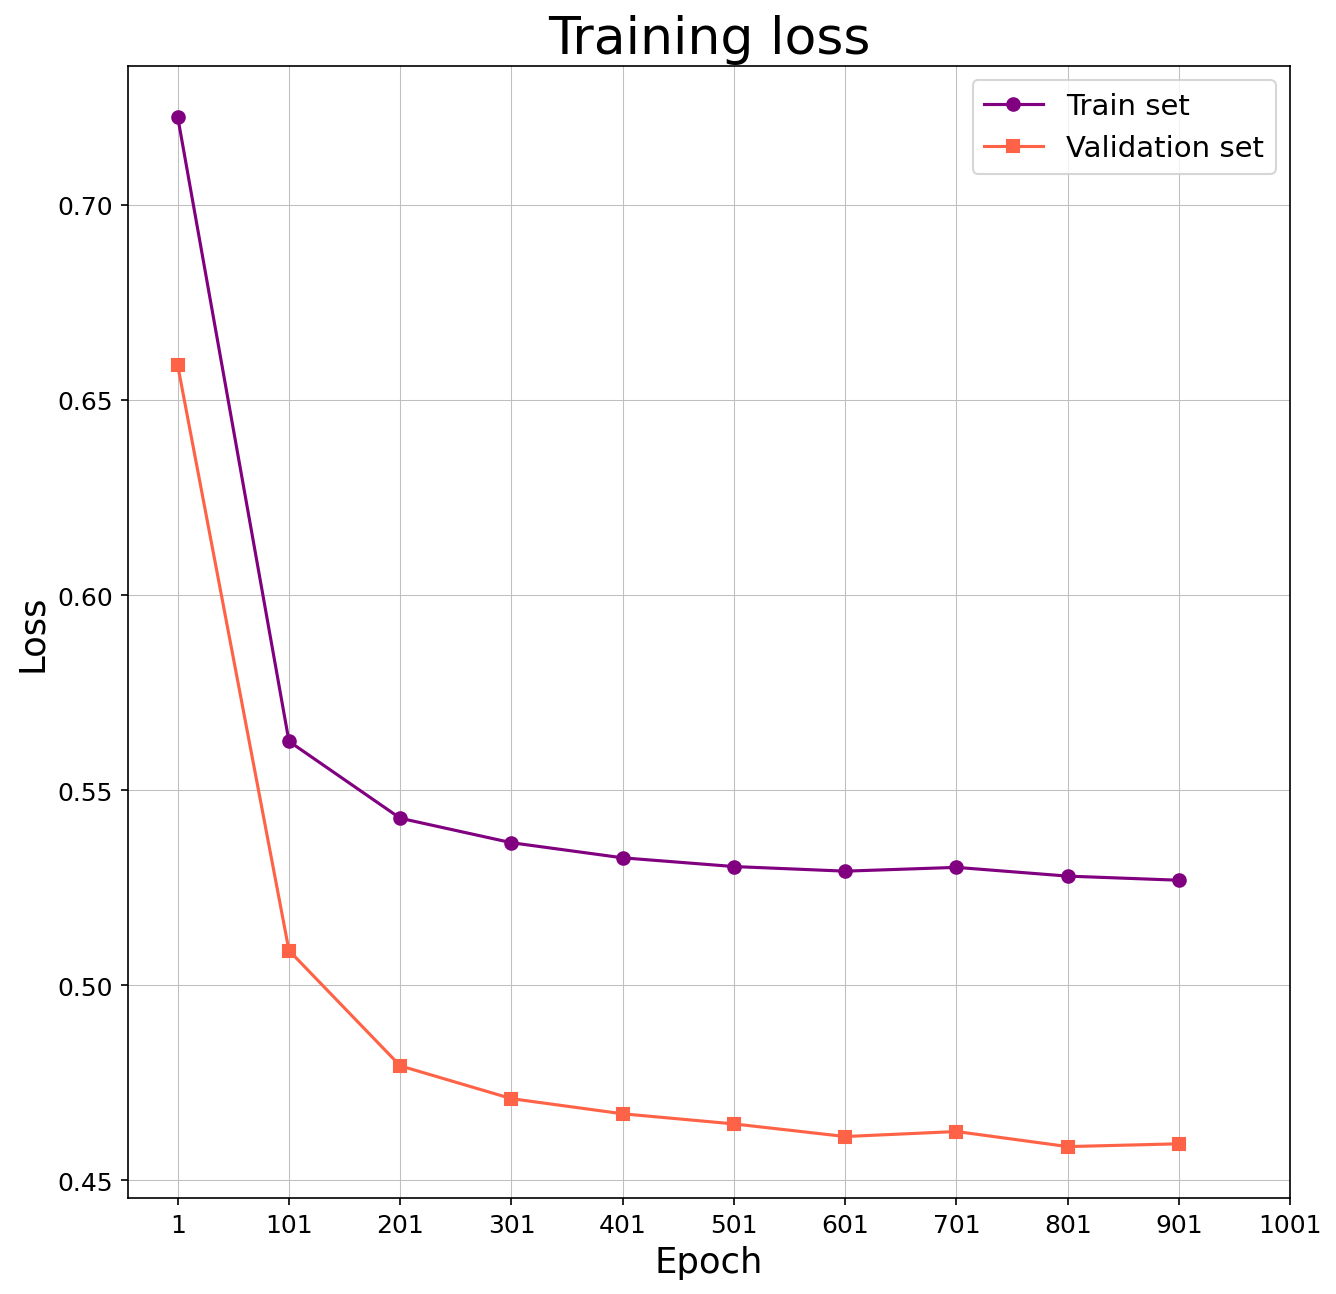

In [16]:
plot_loss(num_epochs, metrics_train, metrics_val, figsize=10, textsize=15, epochs_step=epochs_step)

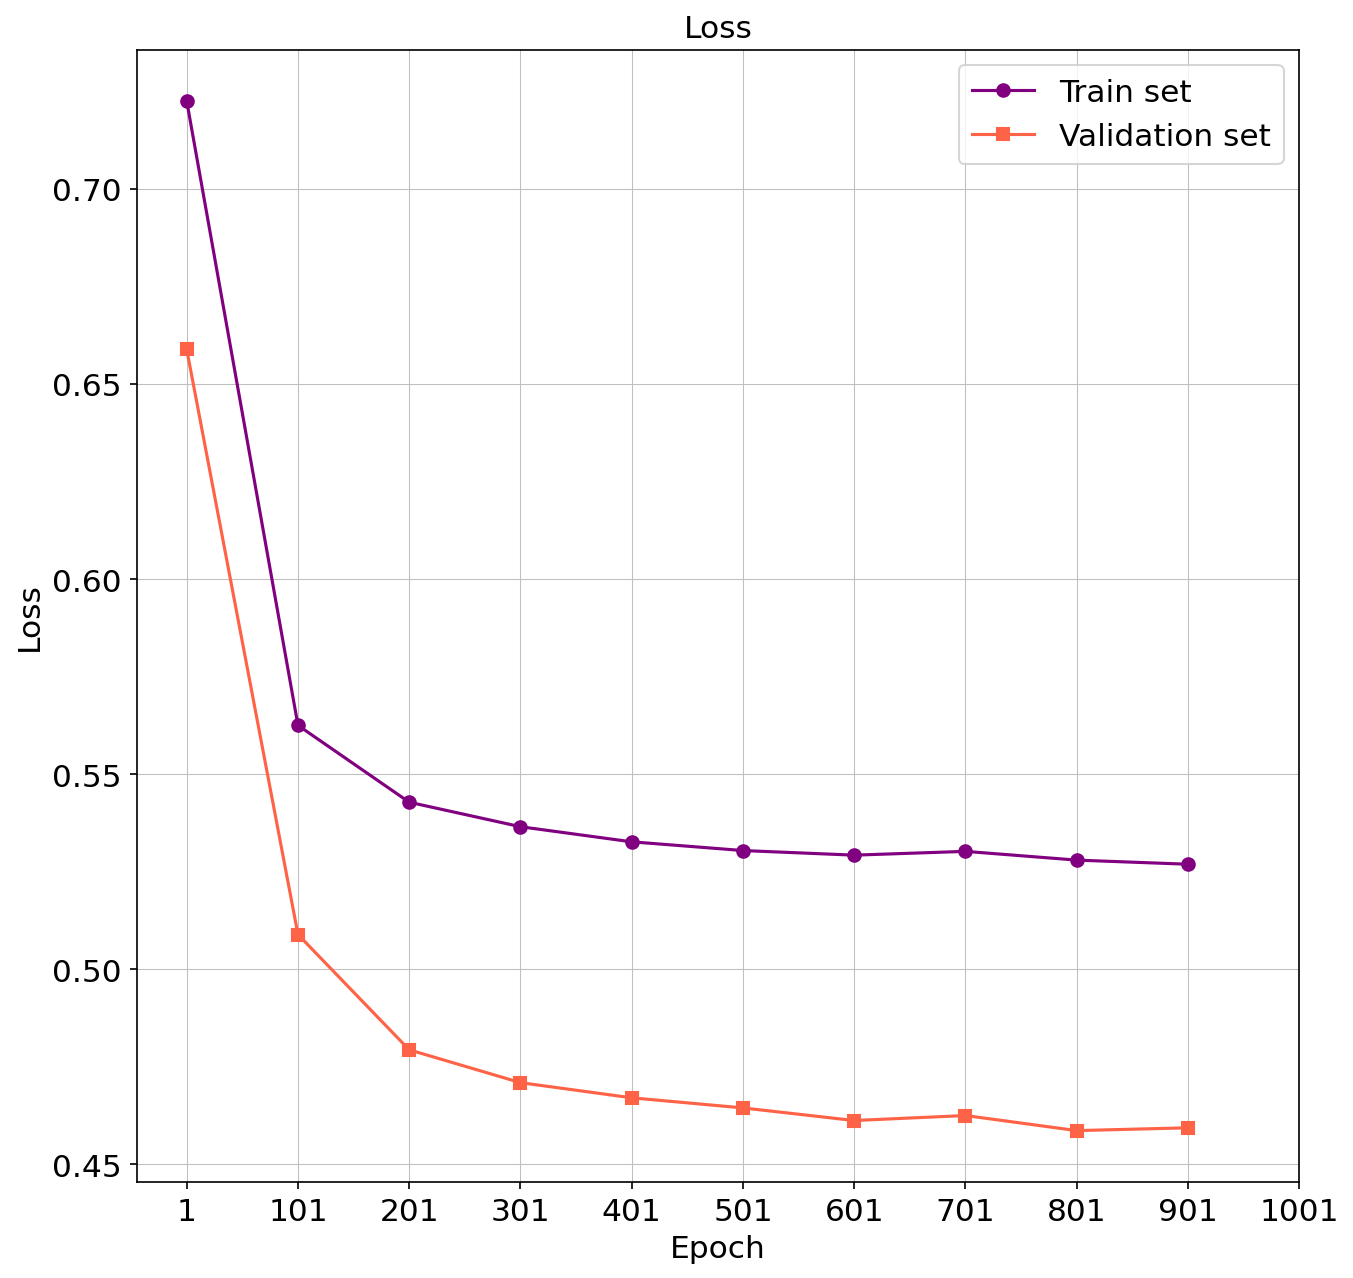

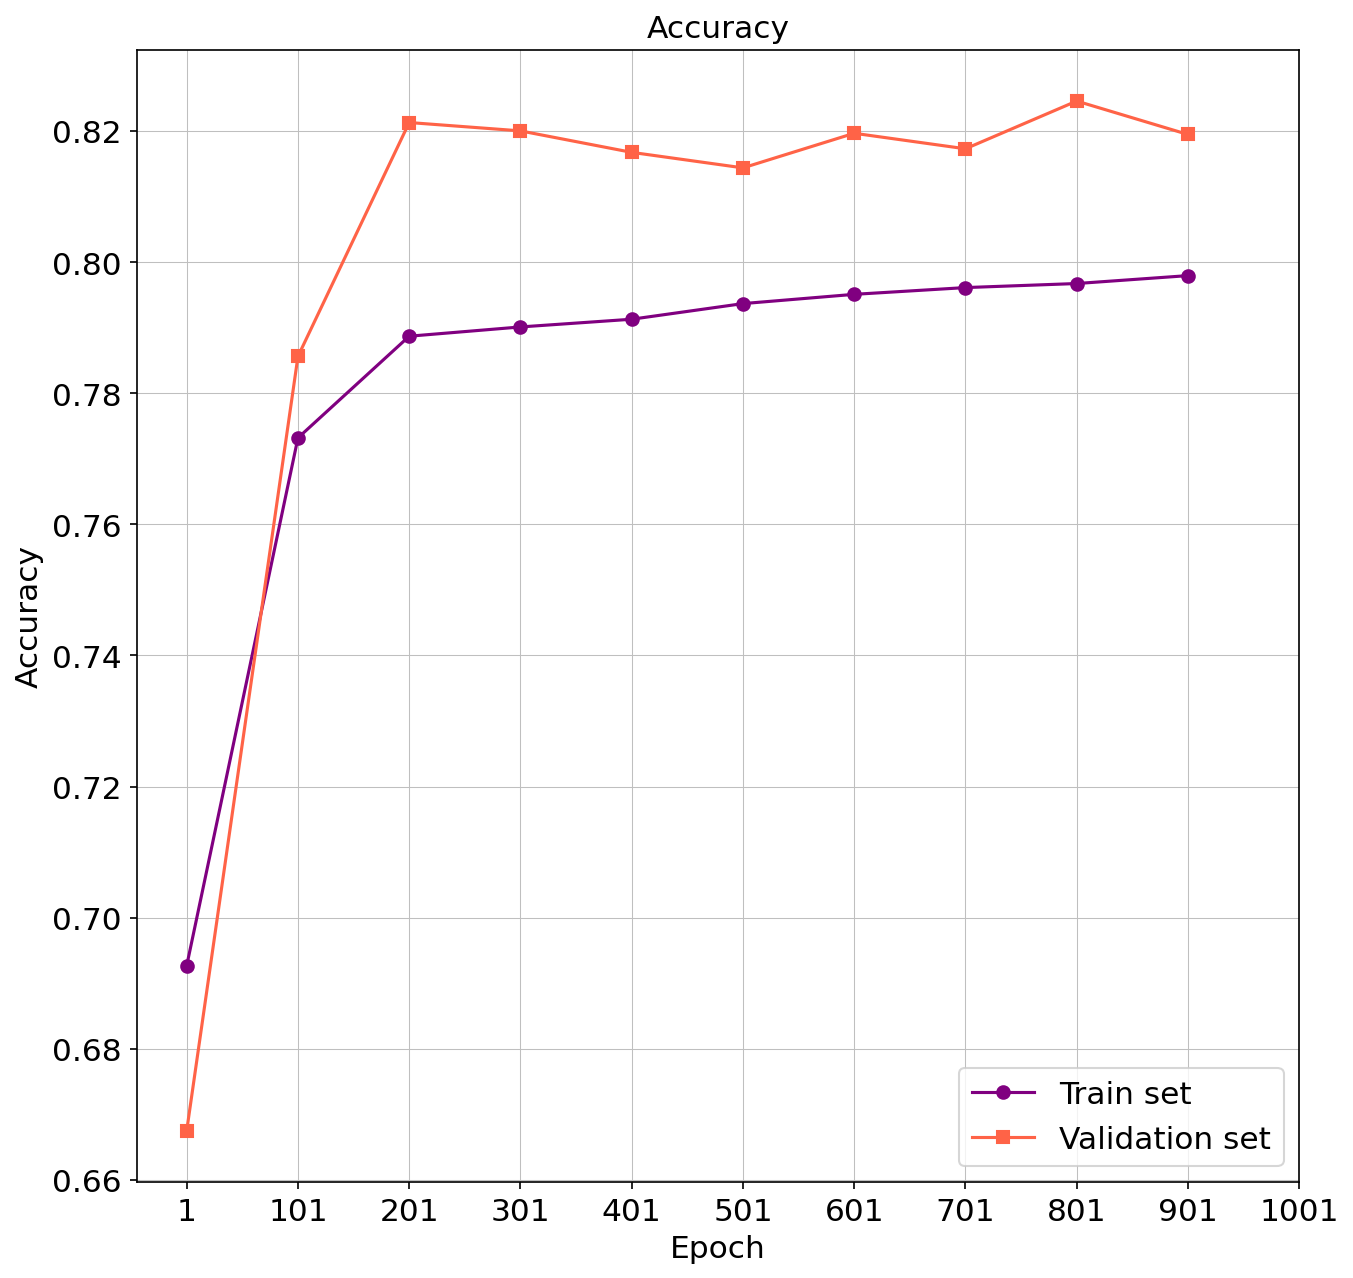

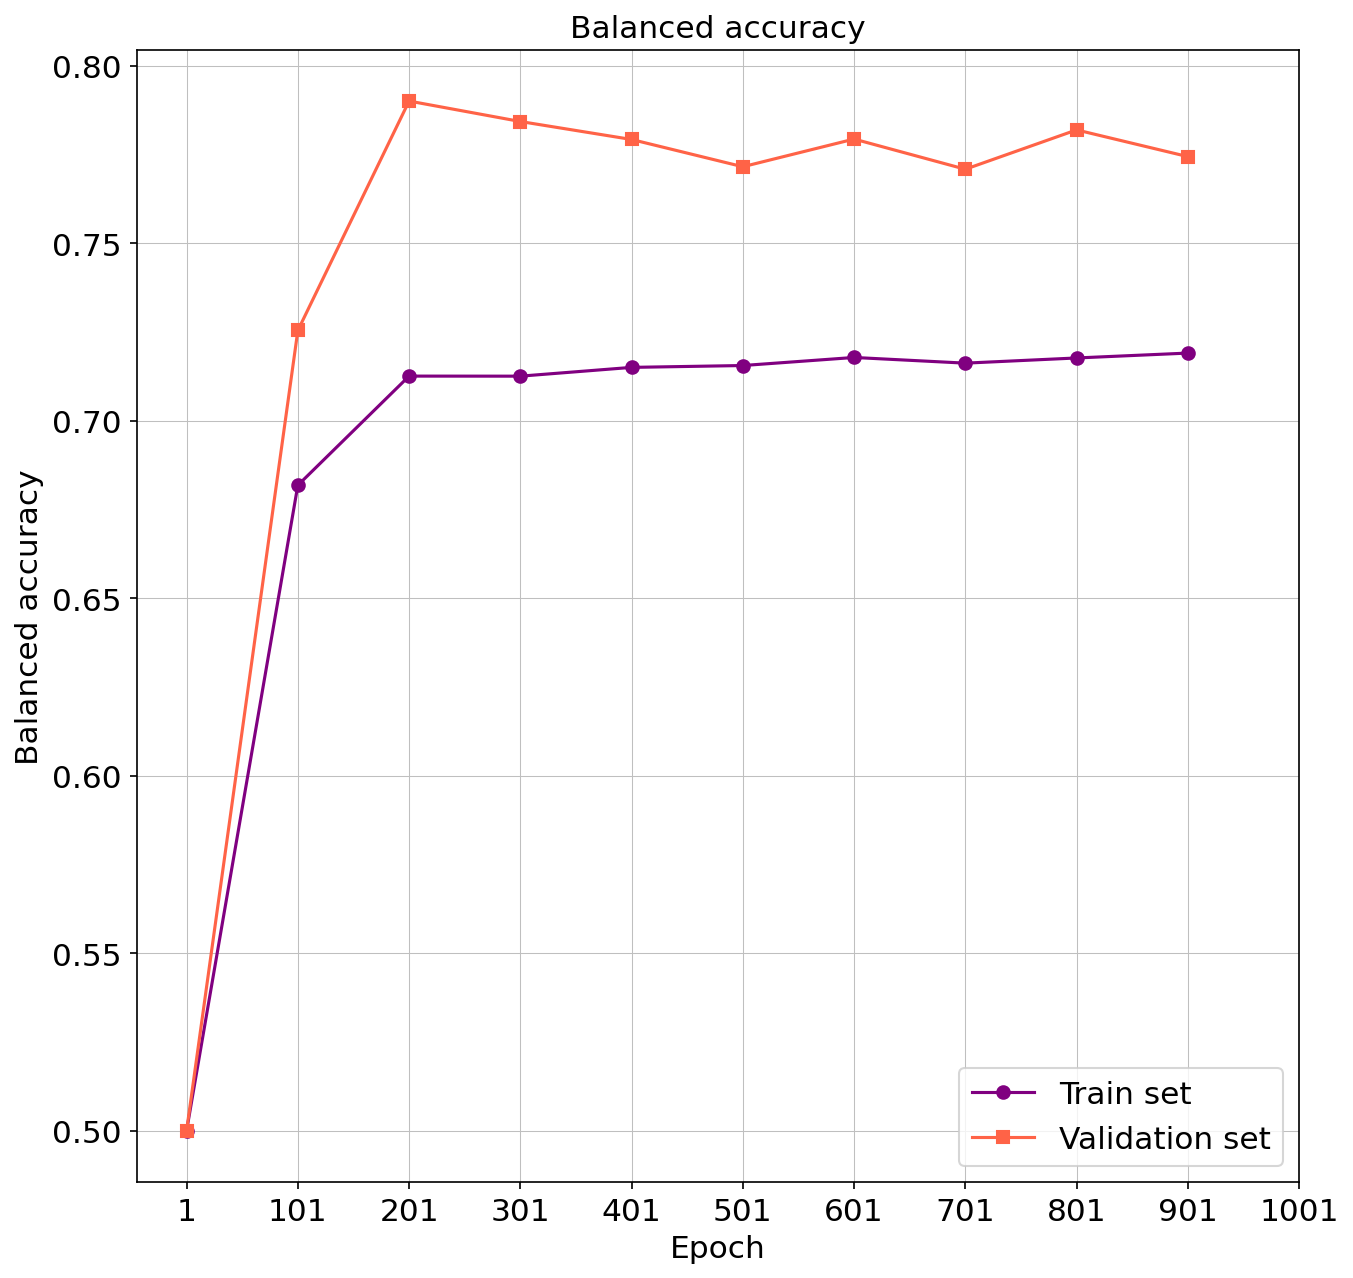

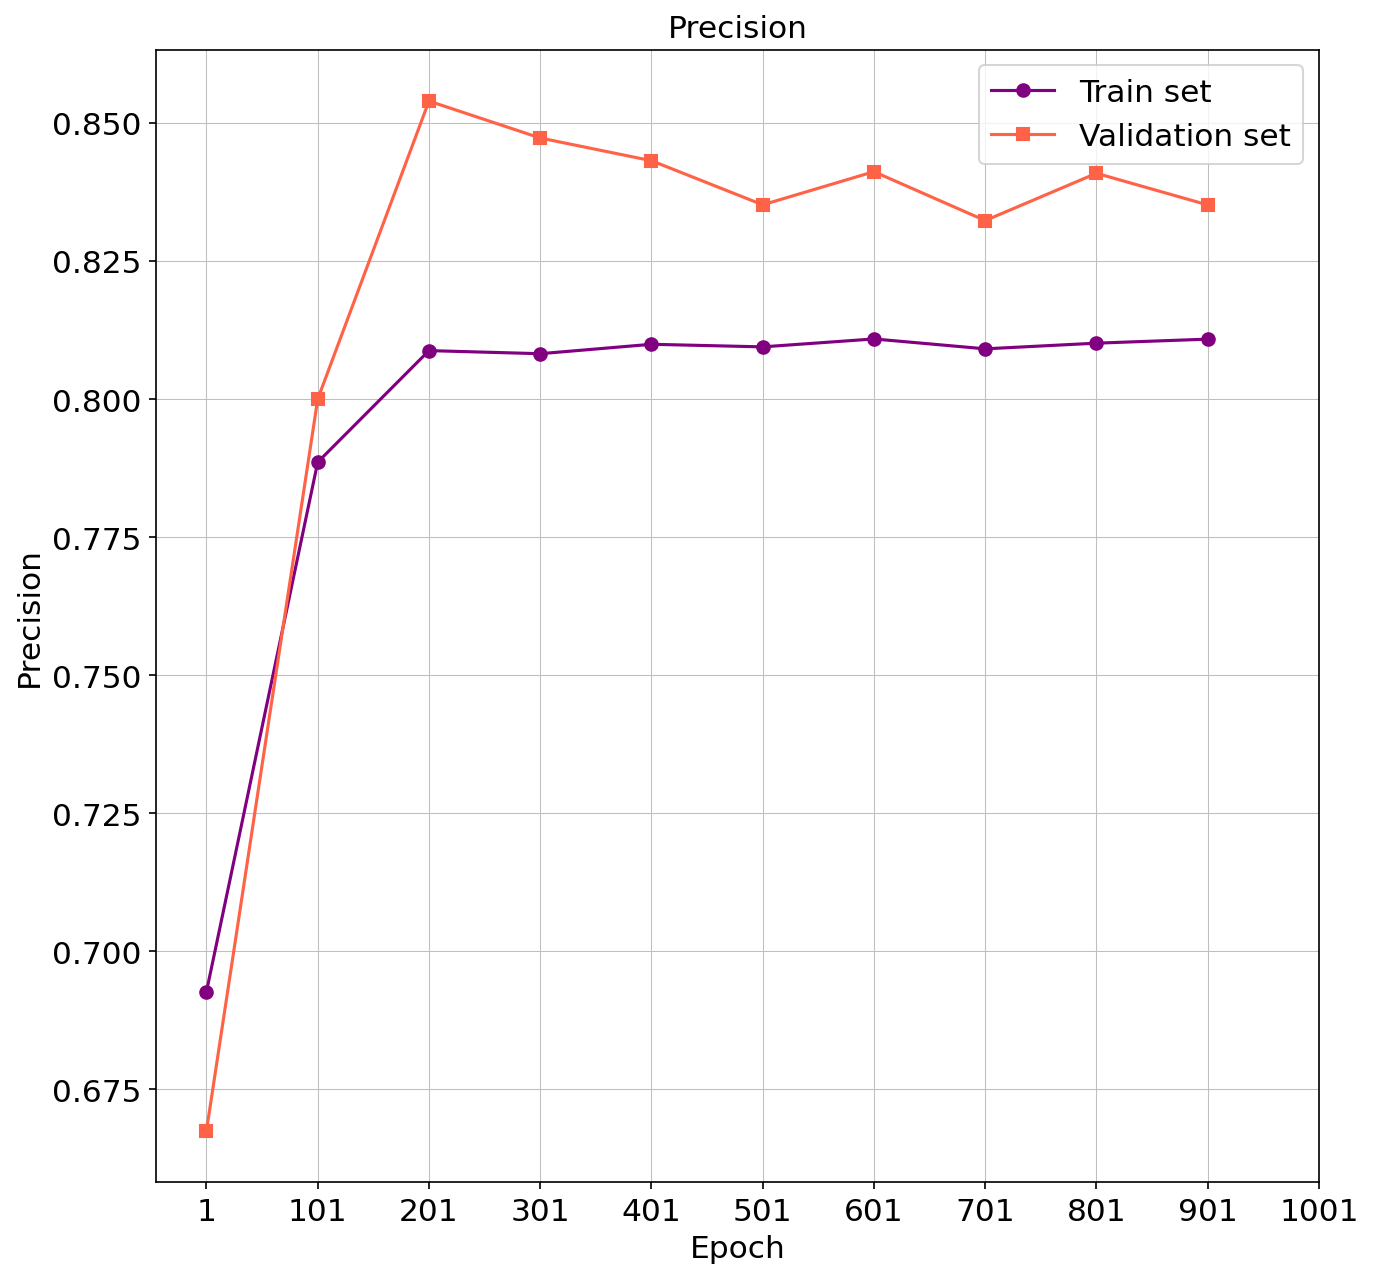

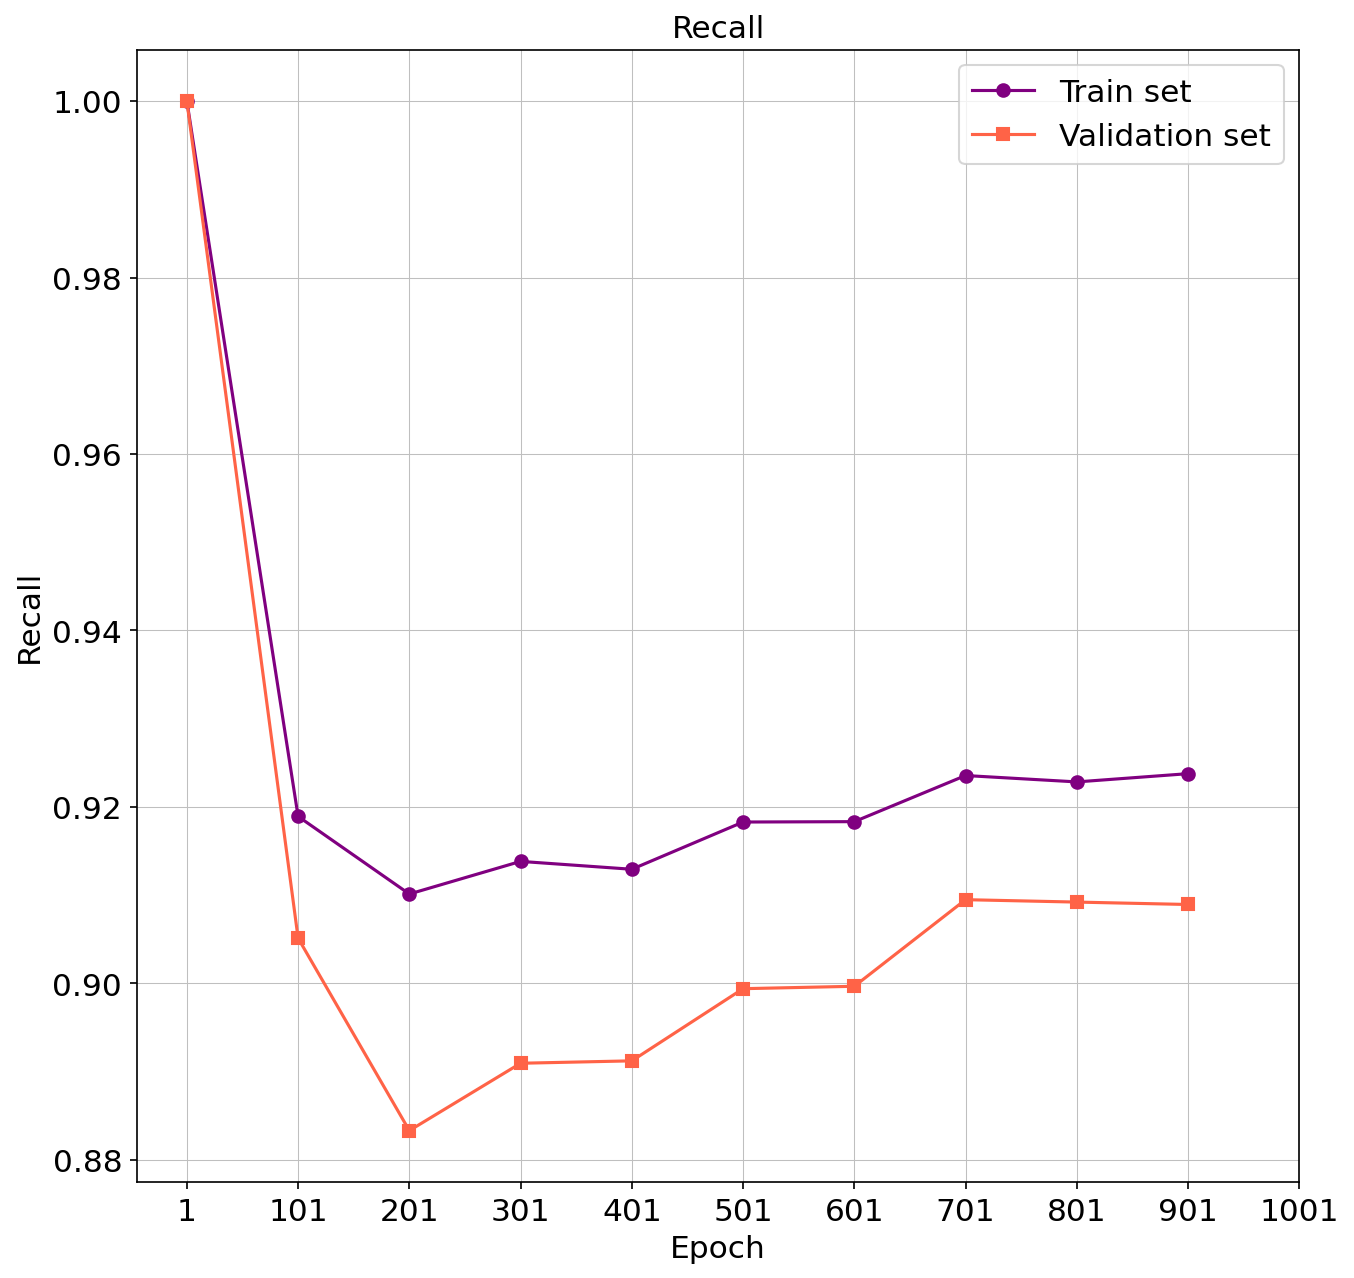

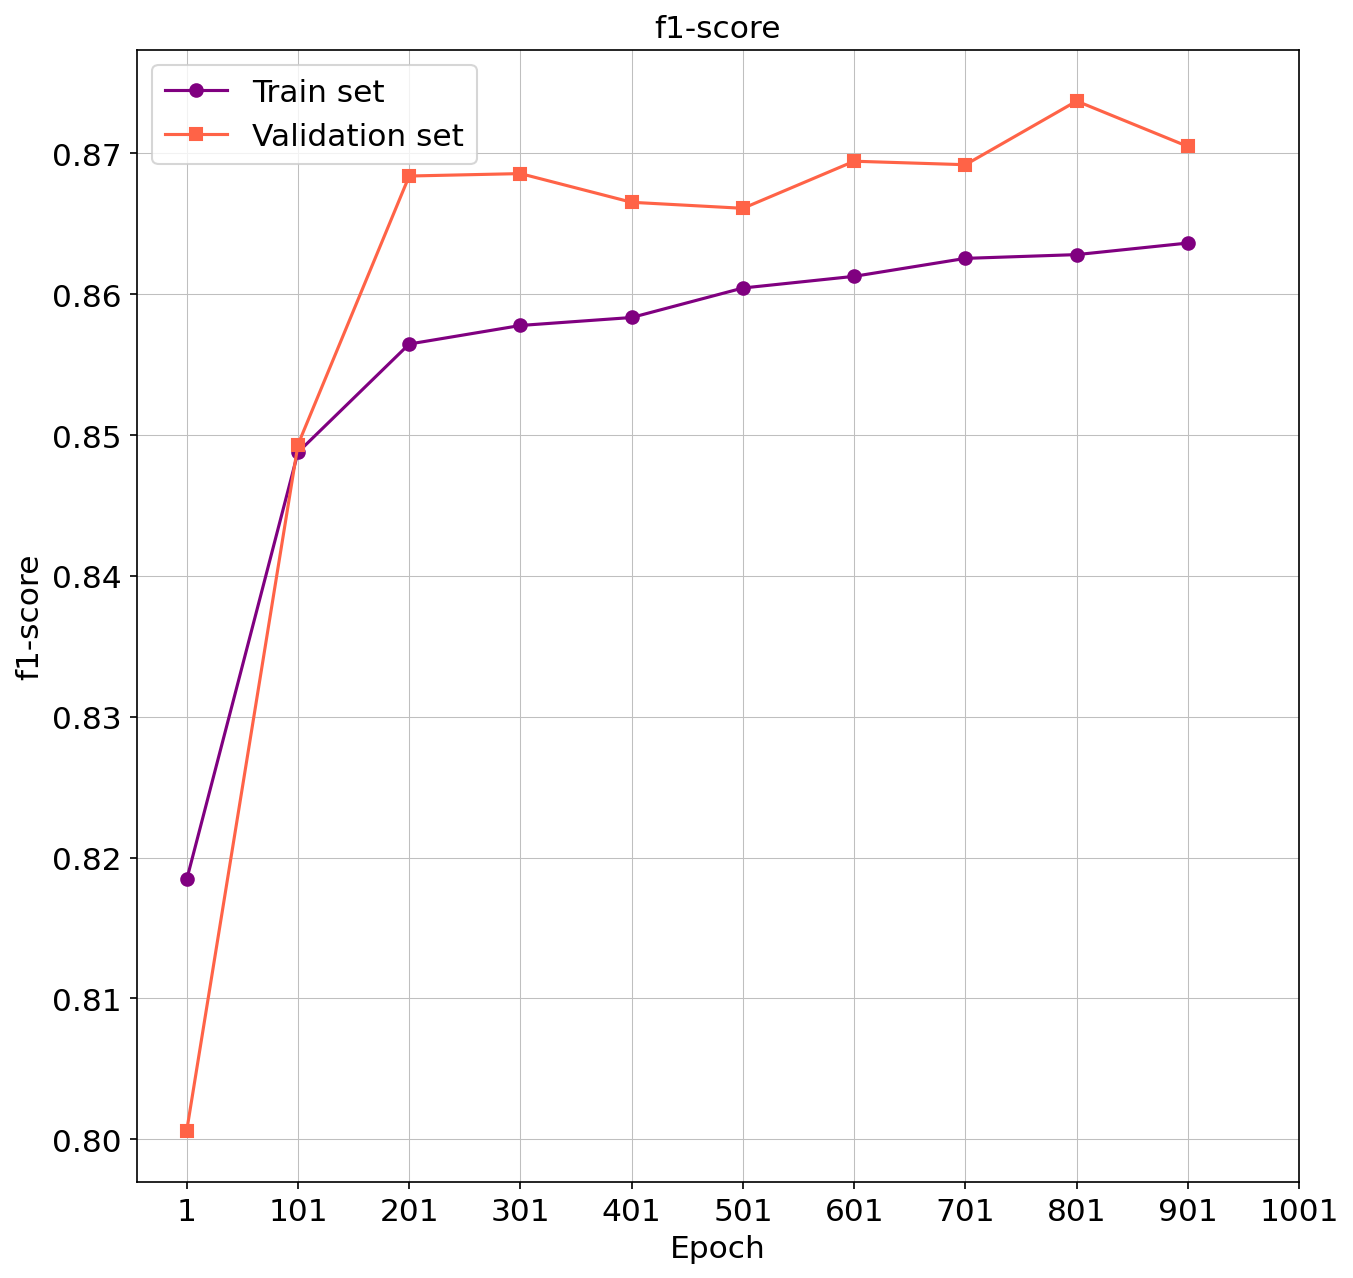

In [17]:
plot_classification_metrics_train_val(num_epochs, metrics_train, metrics_val,
                                      figsize=10, dpi=150, textsize=15, epochs_step=epochs_step,
                                      show=True, folderName='plots/' + datasetName + '/' + modelName)

## ROC curves

### Train set

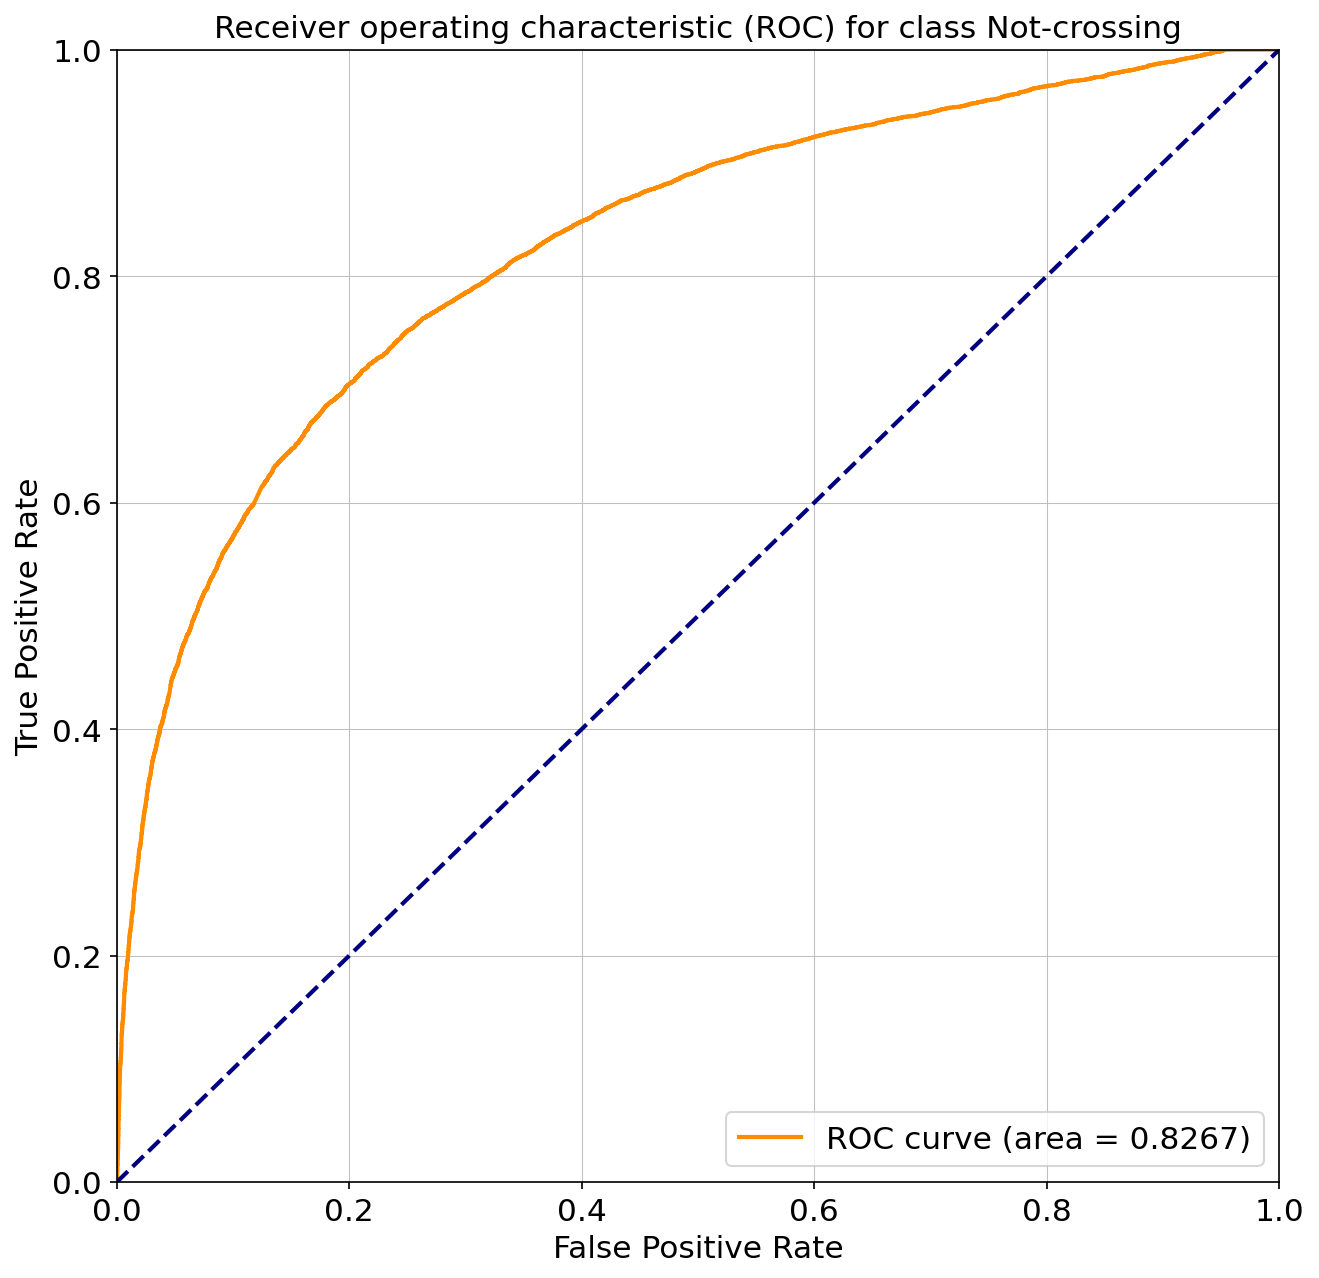

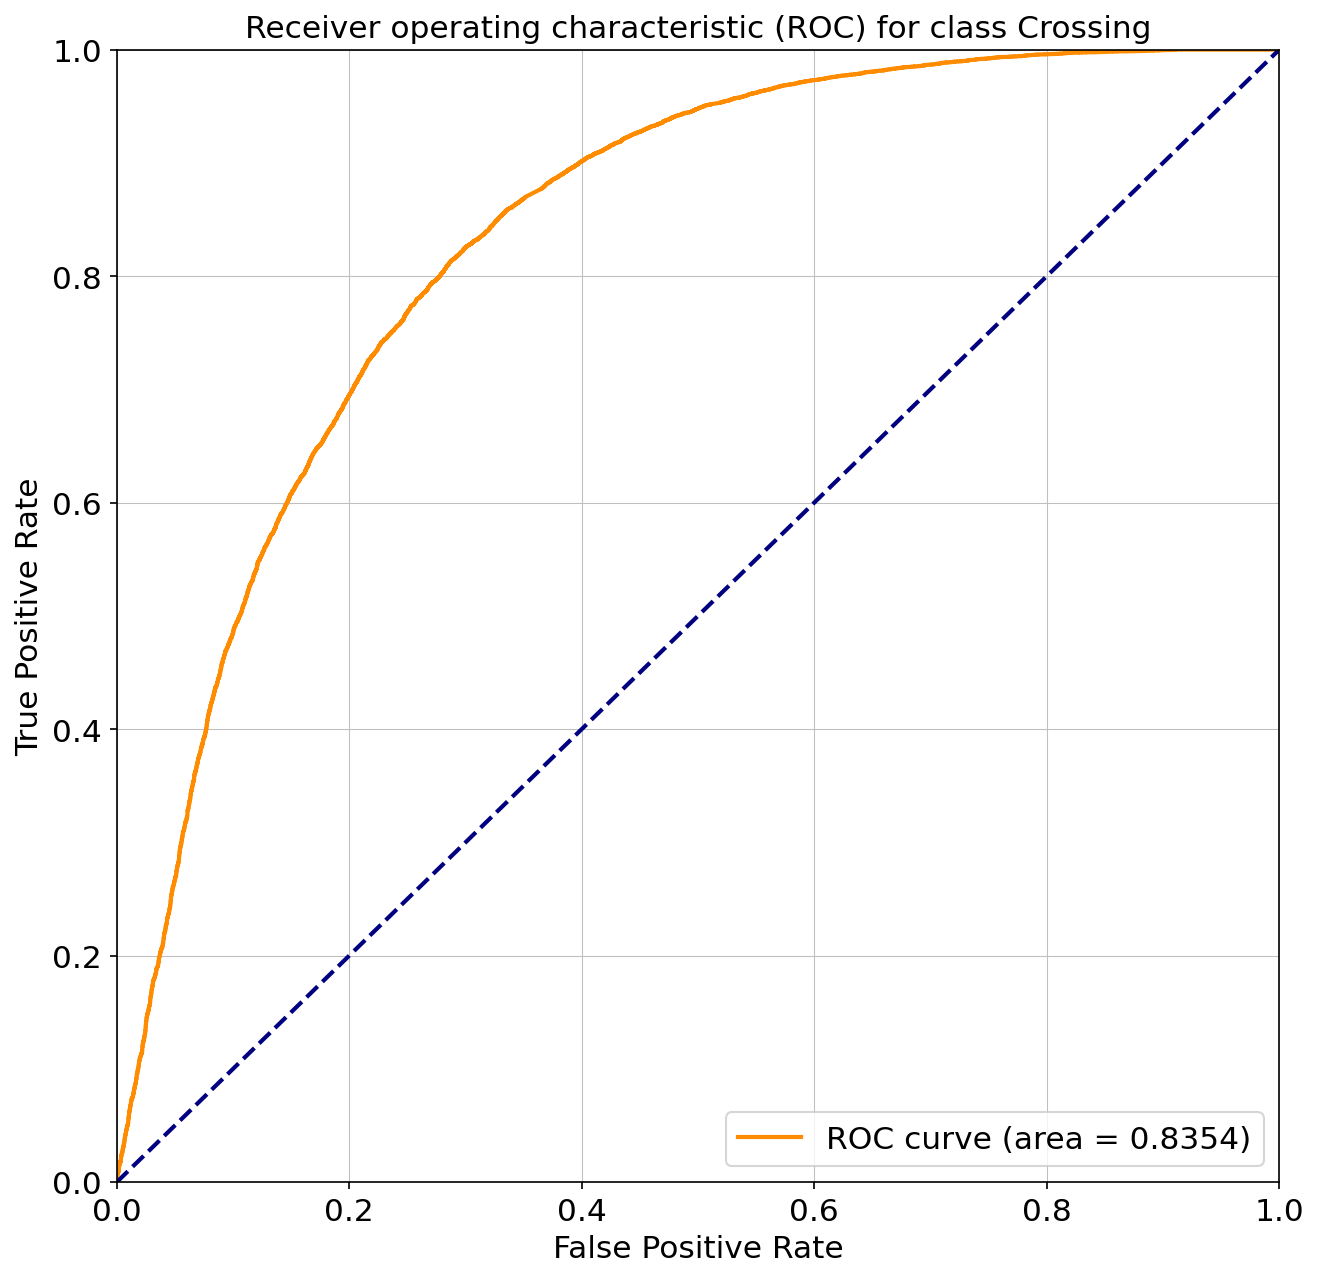

In [18]:
fpr, tpr, roc_auc = ROC(model, train_loader, device, numberOfClasses)

for plotclass in range(0, numberOfClasses):
    plot_ROC(plotclass, fpr, tpr, roc_auc)

### Validation set

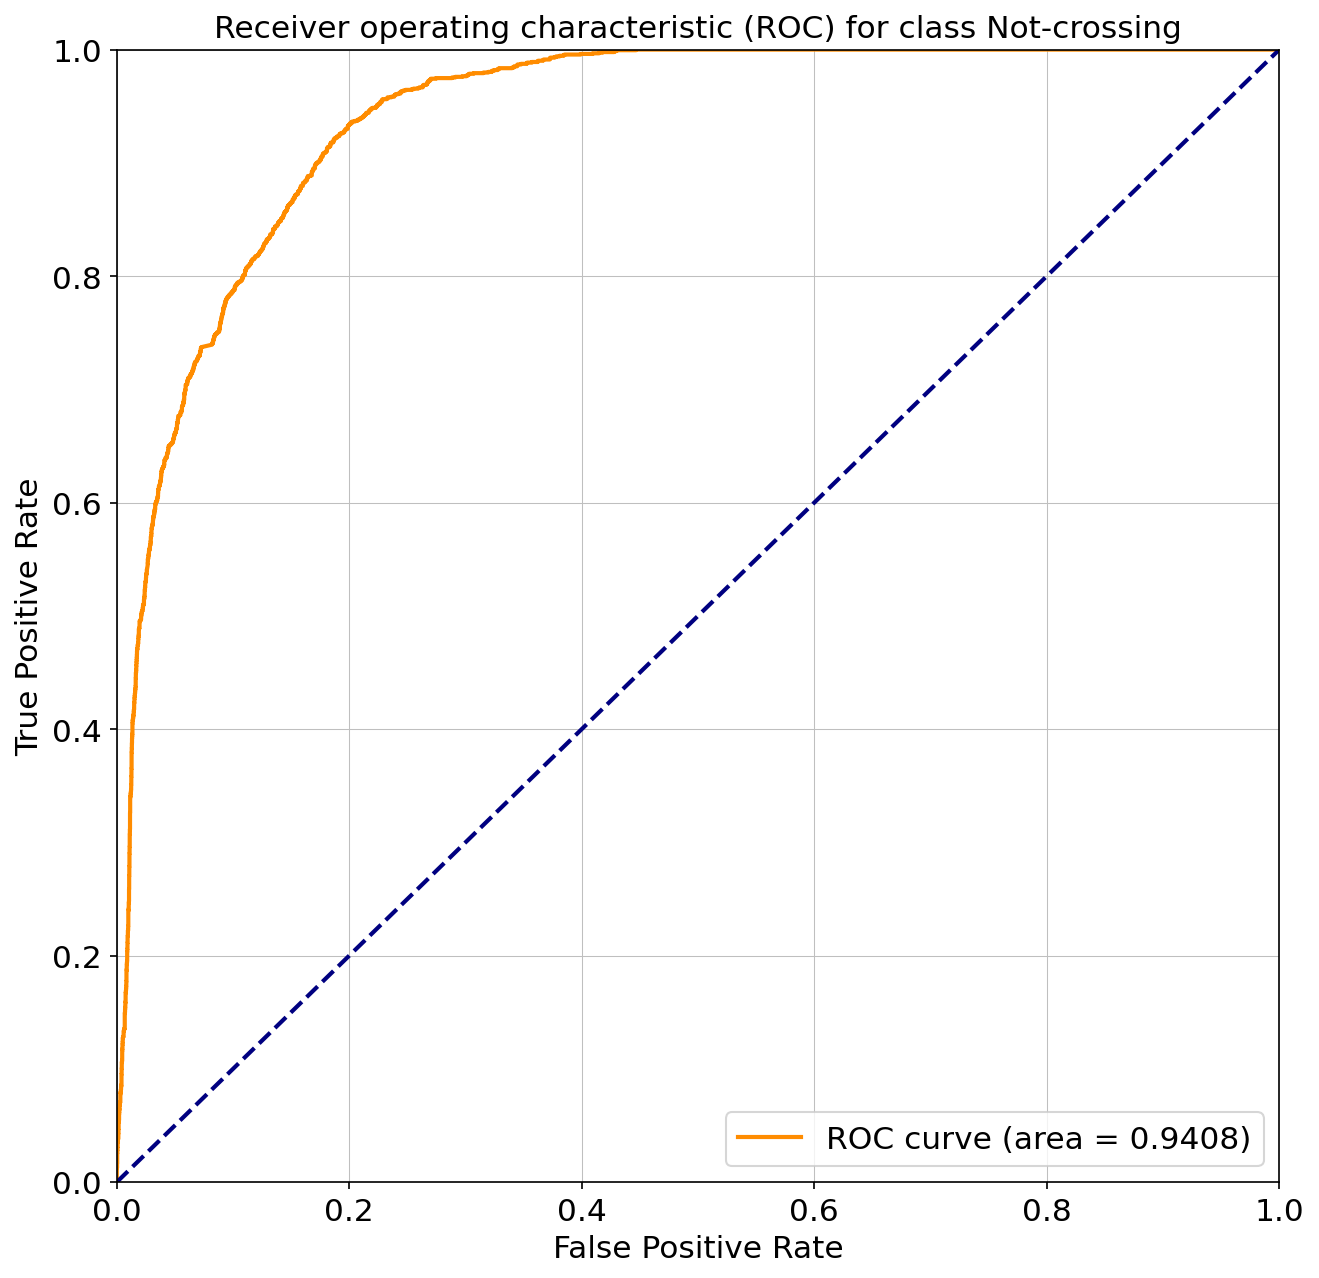

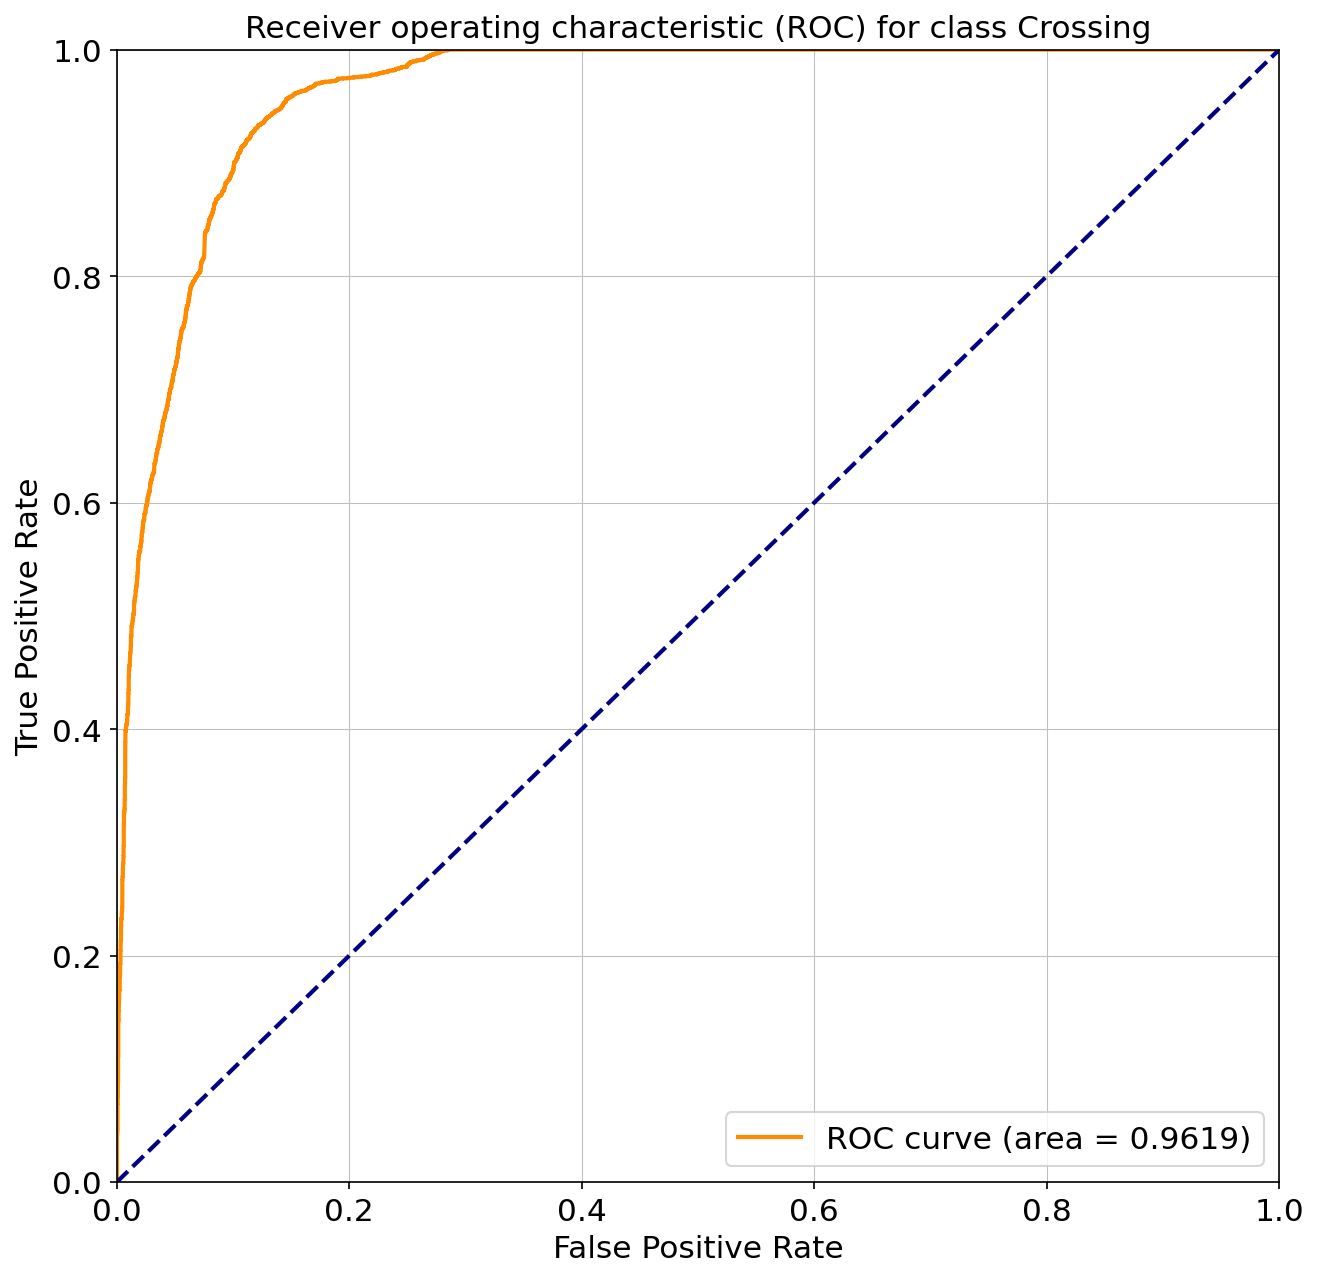

In [19]:
fpr, tpr, roc_auc = ROC(model, val_loader, device, numberOfClasses)

for plotclass in range(0, numberOfClasses):
    plot_ROC(plotclass, fpr, tpr, roc_auc)

# Testing

## Test dataset

In [20]:
subset = 'test'

test_dataset = SkeletonsDataset('Data/' + datasetName + '/' + subset + '_jaad_' + poseEstimator + '.csv',
                           normalization='minmax', target='cross', info=info,
                           remove_undetected=True, numberOfJoints=numberOfJoints)

Number of elements per class:

Test dataset total rows: 52485
Test dataset crossing class samples: 29484
Test dataset not-crossing class samples: 23001


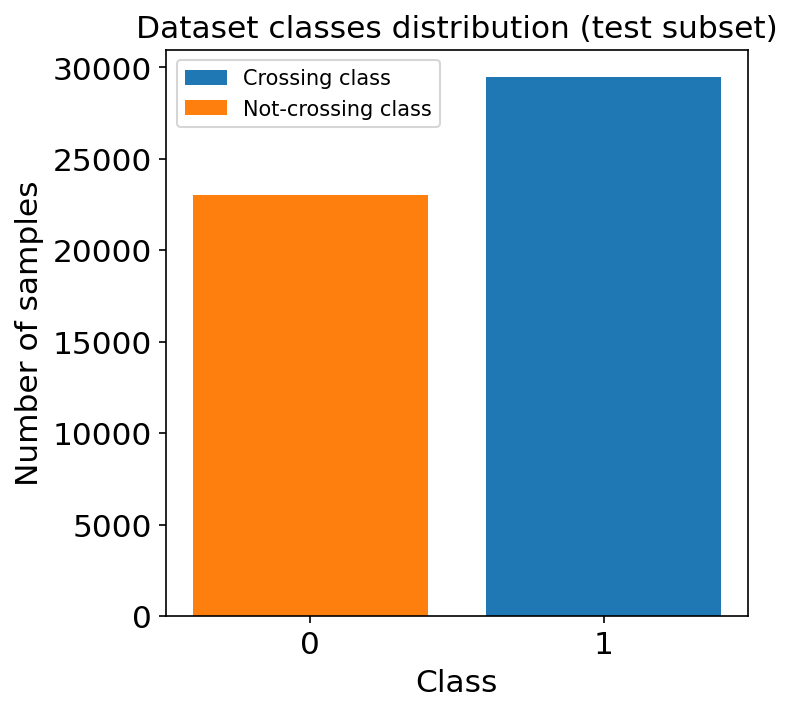

In [21]:
totalRows = len(test_dataset.loadedData)
crossingRows = len(test_dataset.loadedData[test_dataset.loadedData['cross']=='crossing'])
nocrossingRows = len(test_dataset.loadedData[test_dataset.loadedData['cross']!='crossing'])

print('Test dataset total rows:', totalRows)
print('Test dataset crossing class samples:', crossingRows)
print('Test dataset not-crossing class samples:', nocrossingRows)

plt.figure(figsize=(5,5), dpi=150)
plt.bar(1, crossingRows, label='Crossing class')
plt.bar(0, nocrossingRows, label='Not-crossing class')
plt.legend(loc='best')
plt.xticks([0, 1], size=15)
plt.yticks(size=15)
plt.xlabel('Class', size=15)
plt.ylabel('Number of samples', size=15)
plt.title('Dataset classes distribution (test subset)', size=15)
plt.show()

## Test results

In [24]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)
test_metrics = evaluate(model, test_loader, device)


print_evaluation_test(test_metrics)

Testing subset results:

Accuracy:                 0.7641
Balanced accuracy:        0.6866
Precision:                0.7862
Recall:                   0.8988
f1-score:                 0.8388
 




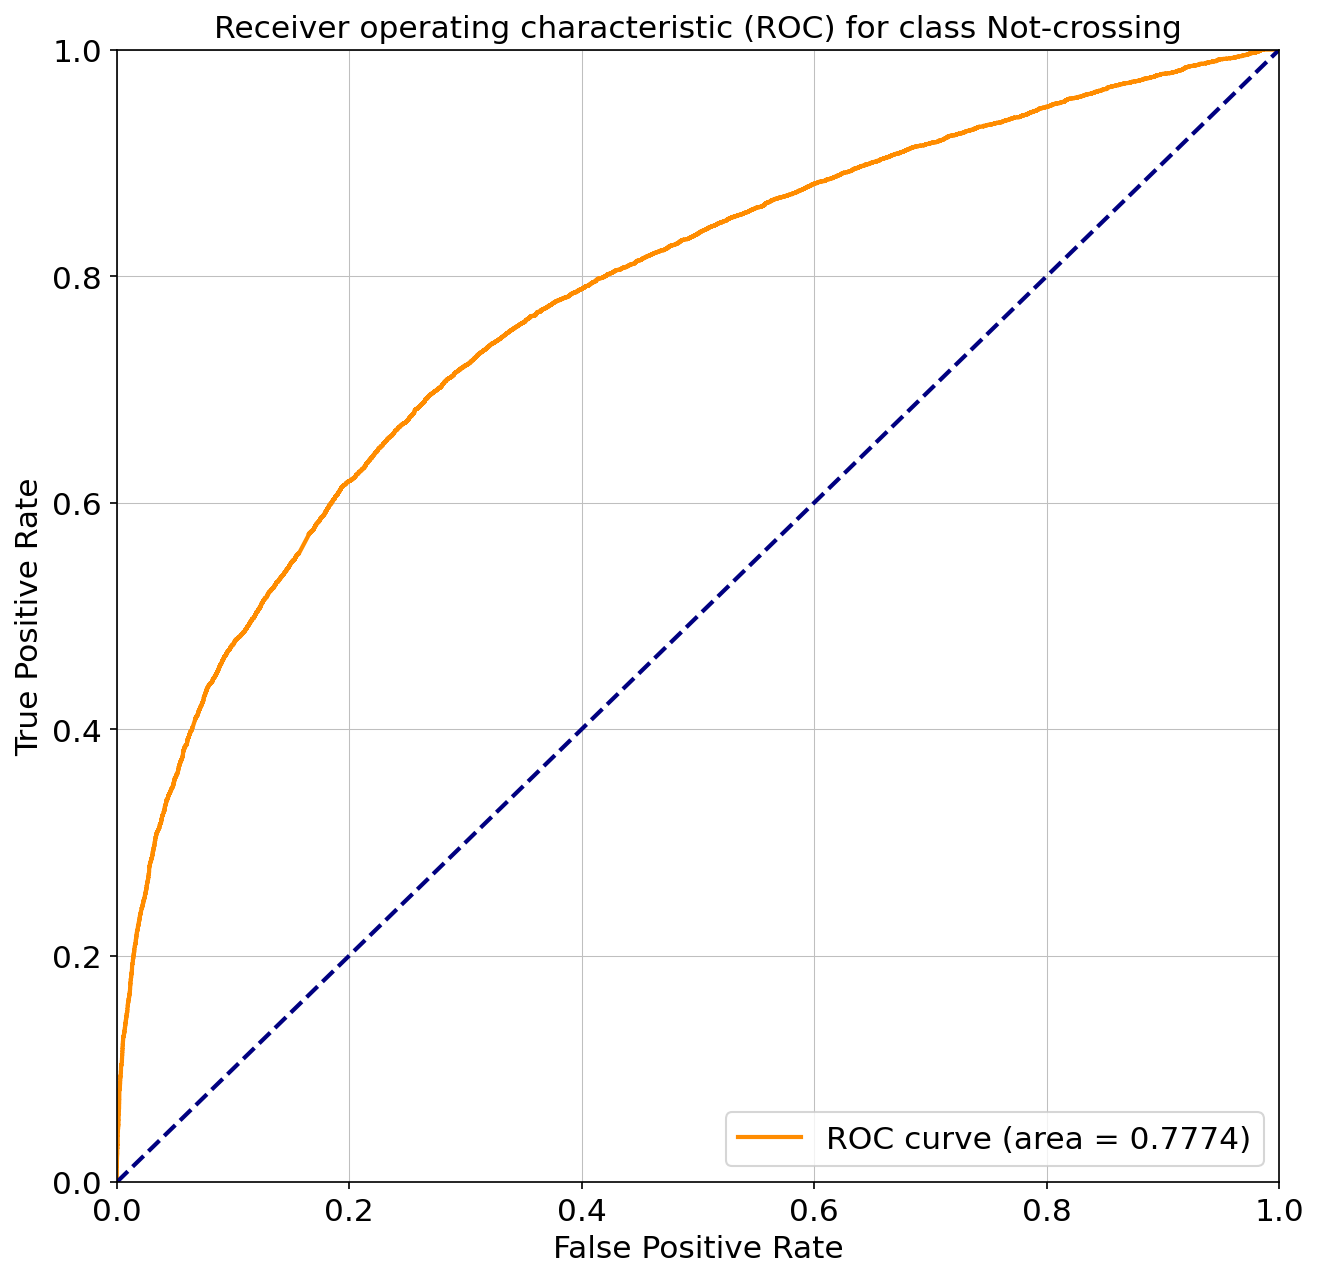

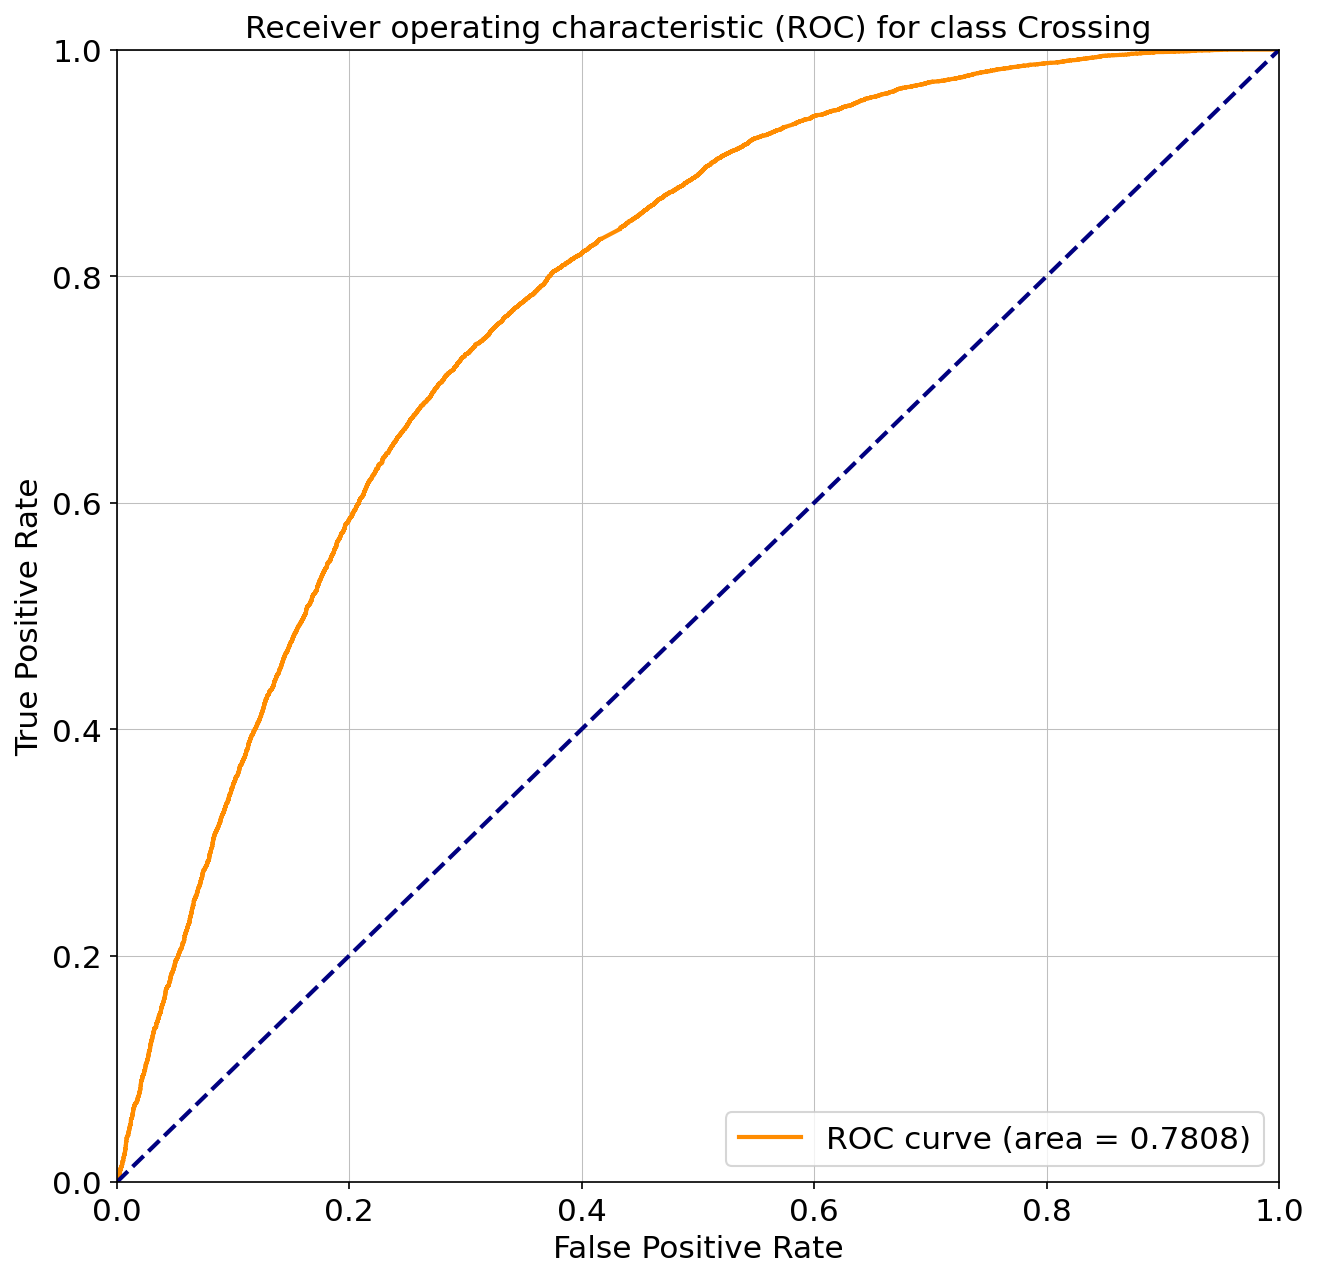

In [25]:
fpr, tpr, roc_auc = ROC(model, test_loader, device, numberOfClasses)

for plotclass in range(0, numberOfClasses):
    plot_ROC(plotclass, fpr, tpr, roc_auc)